In [140]:
%reload_ext autoreload
%autoreload 2

from RingBuffer import RingBuffer
from pyneurode.spike_sorter import *
from sklearn import preprocessing
from utils import *
import numpy as np 
import random
np.random.seed(0)

In [141]:
agg_buffer = RingBuffer.readPickleStreamFile('agg_buffer.pkl')

Total segment read: 125


In [3]:
agg_buffer.shape

(1155, 14)

(1375, 14)


(0.0, 2000.0)

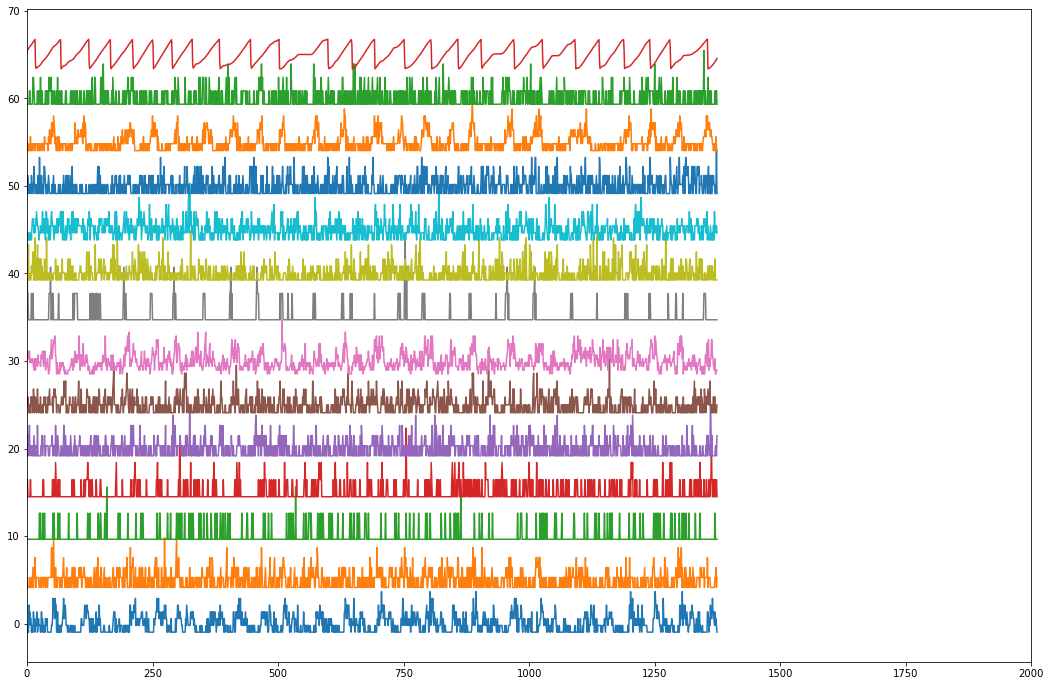

In [142]:
plt.figure(figsize=(18,12))
# signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
scaler =preprocessing.StandardScaler()
print(agg_buffer.shape)
norm_agg_buffer = scaler.fit_transform(agg_buffer)

plot_multichannel(norm_agg_buffer.T,scale=5)
plt.xlim([0,2000])

Total segment read: 14
(1966, 13)


(0.0, 2000.0)

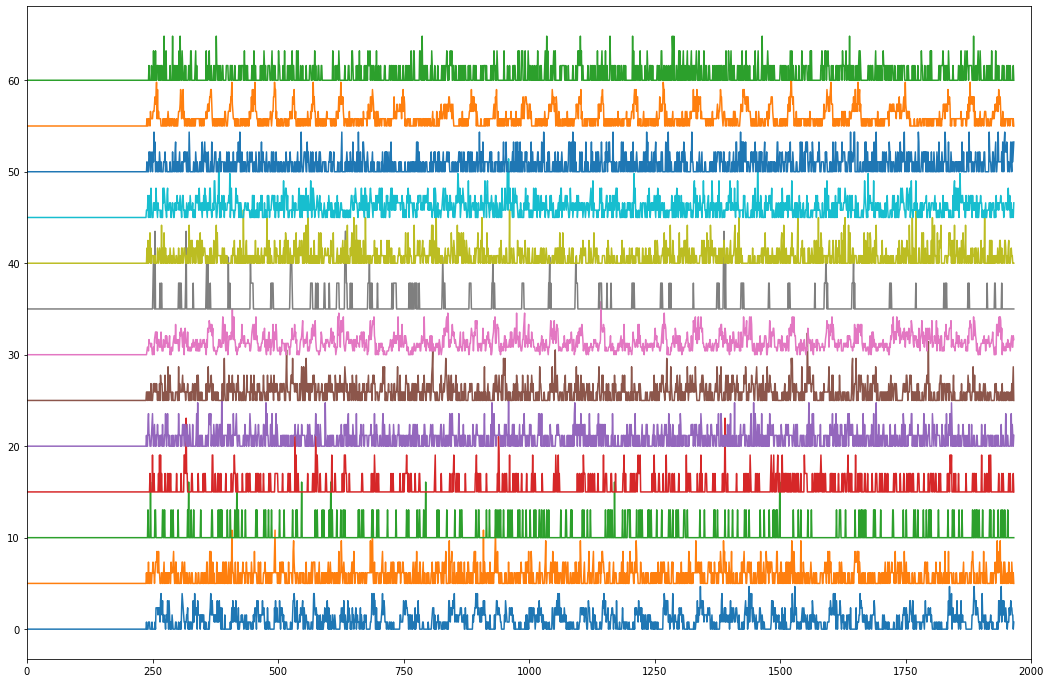

In [144]:
plt.figure(figsize=(18,12))
spike_train_buffer = RingBuffer.readPickleStreamFile('data/spike_train_buffer.pkl')
print(spike_train_buffer.shape)
plot_multichannel(spike_train_buffer.T,scale=5)
plt.xlim([0,2000])

## Emulate online sorting for debugging

In [22]:
data_list = loadPackets('data/data_packets_M2_D23_1210.pkl')
data_list_spk = loadPackets('data/data_packets_M2_D23_1210_spk.pkl')

spikes_data_list = [d['spike'] for d in data_list if 'spike' in d.keys()]
print(len(spikes_data_list))

Reached end. Total segment: 28179
Reached end. Total segment: 20232
20236


(27, 4830080)
624640


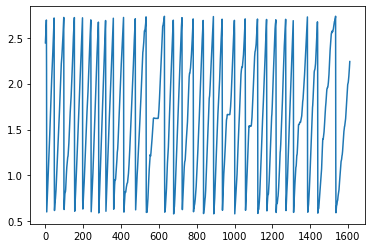

In [23]:
# collect the animal position
Fs = 30000
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
data_ts = [d['data_timestamp'] for d in data_list if 'data_timestamp' in d ]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_ts[0]
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

neuroData = adc_data[:16,:]

Update template takes 0.200s
Match found at 570 on tetrode 1


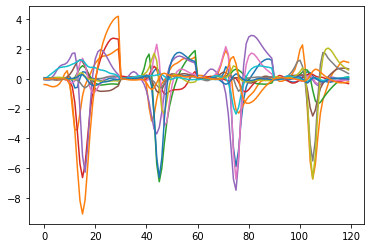

In [138]:
spike_data = []
data_length_per_frame = 200
MIN_NUM_SPIKE=5000
spike_len_prev = 0
state = State()
templates = None #template for matching
template_cluster_id = None #cluster id for each template
sorted_idx_prev = 0
time_bin_start = 0
time_bin = 0.1
buffer_length = int((1/time_bin)*300) #in s
spike_train_buffer = RingBuffer((buffer_length,1),dt=time_bin)
agg_buffer = RingBuffer((buffer_length*5,9),dt=time_bin)
spike_data_idx = 0
spike_data_idx_end = 0
df_sort_residue = None

while(spike_data_idx_end<len(spikes_data_list)):
#     print('.')
    spike_data_idx_end = spike_data_idx + 10
    spike_data+=spikes_data_list[spike_data_idx:spike_data_idx_end]
    spike_data_idx = spike_data_idx_end
    
     # Cluster to find templates
    if (len(spike_data)>(spike_len_prev+MIN_NUM_SPIKE)) and not state.buffer_is_valid: #only sort when enough spikes are collected
        start_time = time.time()
        spike2sort = spike_data.copy() 
        df = makeSpikeDataframe(spike2sort)
        # print(df)
        electrodes_ids = df.electrode_ids.unique()

        df,pca_transformer = sort_all_electrodes(df, pca_component=3) #sort spikes

        #Calculate template
        df_cluster = df.groupby('cluster_id').mean().reset_index()
        cluster_electrode_ids = dict(zip(df_cluster.cluster_id.values, df_cluster.electrode_ids.values))

        spike_waveforms = np.stack(df.spike_waveform_aligned.values)
        cluster_id = df.cluster_id.values


        # Calculate spike templates
        templates,template_cluster_id = calculate_spike_template(spike_waveforms,cluster_id)
        template_electrode_id = np.array([int(cluster_electrode_ids[i]) for i in template_cluster_id])

        # Some book keeping
        # start_timestamp = df.iloc[0].timestamps
        spike_len_prev = len(spike_data) # update previous spike data len
        # state.buffer_is_valid = True #cluster changed, reset spike train
        print(f'Update template takes {time.time()-start_time:.3f}s')
        
        df_temp, ts_shift = syncSpikeTime(df, neuroData)

    # Template matching
    if templates is not None and (sorted_idx_prev<len(spike_data)):

        # do template matching
        spike2sort = spike_data[sorted_idx_prev:]
        df_sort = makeSpikeDataframe(spike2sort)

        df_sort = template_match_all_electrodes(df_sort, templates, template_electrode_id, template_cluster_id)

        sorted_idx_prev += len(df_sort)
        
        # align the spike train with the analog data
        df_sort.timestamps = df_sort.timestamps - ts_shift
        df_sort = df_sort[df_sort.timestamps>=0] #remove all negative time

        # Convert the spike time to time-binned array
        # TODO: need to synchronize the timestamp here
        df_sort['spike_time'] = (df_sort.timestamps.values)/Fs #shift time to be relative to start
        
        #carry over the previous residue
        if df_sort_residue is not None and len(df_sort_residue)>0:
            df_sort = pd.concat([df_sort_residue,df_sort])
        
        bins = np.arange(time_bin_start, df_sort.spike_time.max(), time_bin ) 
        
        # IMPORTANT: leave the spike beyound the bin edge end point to the next cycle
        # otherwise those spike won't be counted
        df_sort_residue = df_sort[df_sort.spike_time>=bins[-1]] # spike is beyond the bin edge, left till next cycle
        df_sort = df_sort[df_sort.spike_time<bins[-1]]
       
        spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df_sort.cluster_id, df_sort.spike_time,bins)
        
        assert np.sum(spk_train[:]) == len(df_sort), 'Some spikes are omitted' #make sure all spikes are included
        
        time_bin_start = bins[-1] #update the start of the bin

        # Save the sorted spikes to buffer
        if state.buffer_is_valid:
            spike_train_buffer.write(spk_train.T)
        else:
            # initialize the spike train buffer
            spike_train_buffer.set_buffer_size((buffer_length,len(template_cluster_id)),
                dt=time_bin)
            spike_train_buffer.write(spk_train.T)
            state.buffer_is_valid = True

(12, 3000)


(0.0, 2000.0)

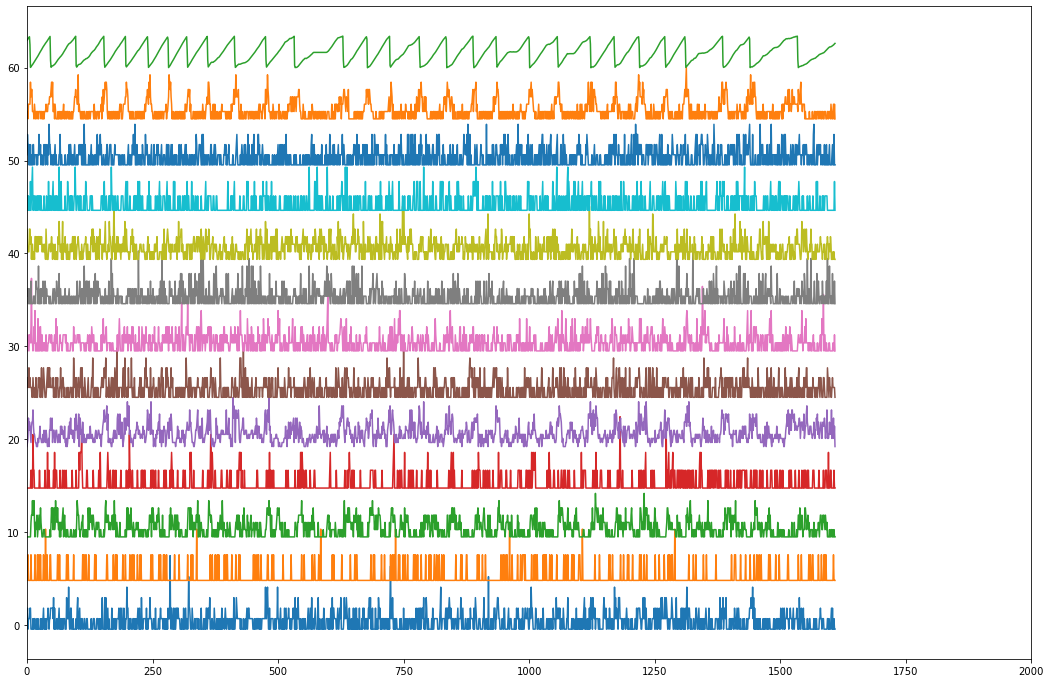

In [139]:
scaler =preprocessing.StandardScaler()
spk_train = spike_train_buffer.buffer.T
print(spk_train.shape)
norm_spiketrain = scaler.fit_transform(spk_train.T)

norm_pos_online = position 
data_length = min(norm_spiketrain.shape[0], norm_pos_online.shape[0])
norm_spiketrain = norm_spiketrain[:data_length,:]
norm_pos_online = norm_pos_online[:data_length]
norm_pos_online = np.round((norm_pos_online-norm_pos_online.min())/(norm_pos_online.max()-norm_pos_online.min())*200)

plt.figure(figsize=(18,12))
signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
plot_multichannel(signal2plot.T,scale=5)
plt.xlim([0,2000])

# plt.figure(figsize=(18,12))
# plot_multichannel(norm_spiketrain,scale=5)
# plt.xlim([0,2000])

## Offline sorting for comparison

In [14]:
data_list = loadPackets('data/data_packets_M2_D23_0910.pkl')
data_list = [d for d in data_list if d]

Reached end. Total segment: 21927


In [15]:
Fs = 30000
spikes_data = [d['spike'] for d in data_list if 'spike' in d.keys()]
df_spikes = makeSpikeDataframe(spikes_data)
df_spikes.sort_values('timestamps',inplace=True)
print(len(df_spikes))
df_spikes.head()


15738


,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps
0,"[0.54815173, 0.10578059, -0.20589569, -0.26805...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,548577
1,"[-0.46256727, -1.1138308, -1.9782073, -2.22664...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,548708
2,"[0.2714859, -0.11896385, -0.47404528, -0.53017...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,549123
3,"[0.9285795, 1.3382688, 1.3920064, 1.3055677, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,549175
4,"[0.41949302, 0.76048064, 0.96505475, 0.7137311...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,549473


(27, 3772160)
547200
Match found at 718 on tetrode 3


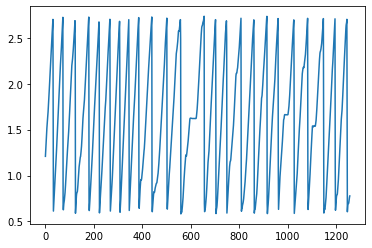

In [17]:
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
data_ts = [d['data_timestamp'] for d in data_list if 'data_timestamp' in d ]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_ts[0]
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

neuroData = adc_data[:16,:]

# synchronize
df_spikes = syncSpikeTime(df_spikes,neuroData)

# sorting
spikes2sort=5000 #15000
df_ref, df_online,template_cluster_id = sort_spikes_online(df_spikes.loc[:spikes2sort], df_spikes,pca_component=3)

(13, 1257)
(1257, 13)


(0.0, 2000.0)

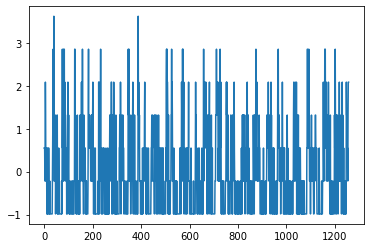

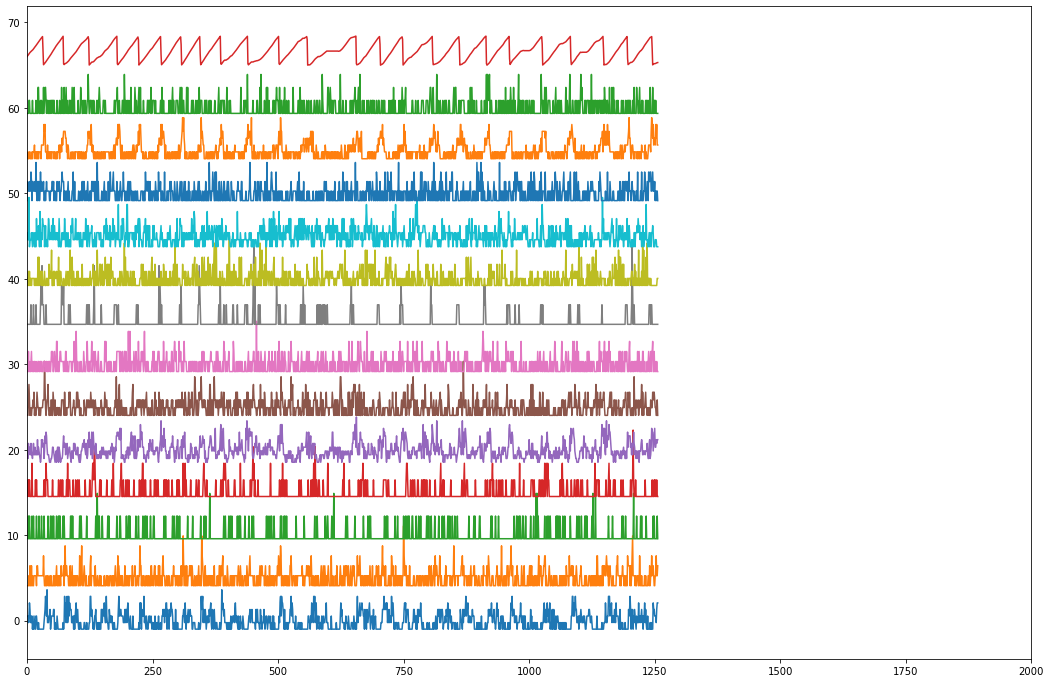

In [21]:
# make firing rate array
Fs = 30000
time_bin = 0.1
time_bin_start=0

df2decode = df_online

# convert to binned spiketrain
spike_time = (df2decode.timestamps.values)/Fs #shift timestamp
bins = np.arange(time_bin_start, spike_time.max(), time_bin )
spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df2decode.cluster_id, spike_time, bins)
print(spk_train.shape)

#normalize the firing rate
scaler =preprocessing.StandardScaler()
meanFr = spk_train.mean(axis=1)
norm_spiketrain = scaler.fit_transform(spk_train[meanFr>0.1,:].T)
print(norm_spiketrain.shape)
# norm_spiketrain=spk_train.T
plt.plot(norm_spiketrain[:,0])

norm_pos_online = position 

data_length = min(norm_spiketrain.shape[0], norm_pos_online.shape[0])
norm_spiketrain = norm_spiketrain[:data_length,:]
norm_pos_online = norm_pos_online[:data_length]

norm_pos_online = np.round((norm_pos_online-norm_pos_online.min())/(norm_pos_online.max()-norm_pos_online.min())*200)

plt.figure(figsize=(18,12))
signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
plot_multichannel(signal2plot.T,scale=5)
plt.xlim([0,2000])